<div style="text-align: right"> Name: Alexander Snouffer

#  <center>                                          Homework 3 - Due Date: 23/04/2020
   

## <center> 2D Multi-element airfoil

This is your [_AeroPython_](https://github.com/barbagroup/AeroPython) assignment for the fourth course module, titled **"Vortex-panel method for lifting bodies."** You will investigate a 2D multi-element airfoil, or wing section with extended flap, adapting the source-vortex panel method of [Lesson 11](11_Lesson11_vortexSourcePanelMethod.ipynb) to compute the flow around two airfoils. 

The key concepts for using the vortex-source panel method with a multi-element airfoil are:

1. each airfoil has its own vortex strength, and
2. the trailing edge at each airfoil must follow the Kutta condition.

In the first part of the assignment, you will use a test for which we have a theoretical solution, due to Williams (1973). Have a look at the reference, and get a feel for its mathematical genius! In the second part, you will use a more popular airfoil (the NACA 23012) for both the main wing section and the flap. For this case, there is an old classic NACA report by Wenzinger (1938) giving data from experiments in a wind tunnel. This exercise will get you wondering about some very interesting aerodynamical questions!

## Part 1: Williams' test case

Your task is to calculate the pressure coefficient on a multi-element wing section, consisting of a *main airfoil* and an *external-airfoil flap*. This test is from Williams (1973), who obtained a beautiful theoretical solution using the techniques of conformal mapping.

The profile of the wing section looks like this, with flap extended:
<center> <img src="MultiElementAirfoil.png" width="500"> </center>

We provide CSV files with the $x$ and $y$ coordinates for the end nodes of each panel. The files have the following naming convention, where `***` represents the value of `N`, the number of panels: `MainFoil_N=***.csv`, `FlapFoil_N=***.csv`.

You can use fewer panels for debugging while developing your codes and then use more panels for more serious calculations when answering the questions in this assignment.

There are also two files named `Cp_Main_theoretical.csv` and `Cp_Flap_theoretical.csv` containing the theoretical values of pressure coefficient versus $x$-coordinates, for the flap configuration we give you in the data files (a $30$º flap deflection, with the main airfoil at $0$º angle of attack).

The theoretical lift and drag force for potential flow over this 2D wing section with zero angle of attack are $3.7386$ and $0$, respectively (non-dimensionalized by dynamic pressure).


### Hints

Recall the [exercise in Lesson 11](11_Lesson11_Exercise.ipynb), which asks you to derive the mathematical formulation of the vortex-source panel method. 

Now, for the 2-element airfoil, you need to derive the required mathematical expressions, following the same process as in the exercise, starting from the following expression for the potential:

$$
\begin{split}
\phi(x, y) &= U_{\infty}x\cos\alpha + U_{\infty}y\sin\alpha \\
& + \int_{main} \frac{1}{2\pi} \sigma(s) \ln \sqrt{(x-\xi(s))^2+(y-\eta(s))^2} ds  \\
& + \int_{flap} \frac{1}{2\pi} \sigma(s) \ln \sqrt{(x-\xi(s))^2+(y-\eta(s))^2} ds \\
& - \int_{main} \frac{1}{2\pi} \gamma(s) \tan^{-1} \frac{y-\eta(s)}{x-\xi(s)} ds  \\
& - \int_{flap} \frac{1}{2\pi} \gamma(s) \tan^{-1} \frac{y-\eta(s)}{x-\xi(s)} ds
\end{split}
$$

Assume the following:

1. $\sigma(s)$ is constant on each panel, 
2. $\gamma(s)$ is constant on each airfoil, and
3. the 1<sup>st</sup> to $N_a$<sup>th</sup> panels are on the main airfoil and the $(N_a+1)$<sup>th</sup> to $N$<sup>th</sup> panels are on the flap (where $N=N_a+N_b$, and $N_b$ is the number of panels on the flap).

There will be $N+2$ unknowns, that is, $\sigma_1\cdots\sigma_N$, $\gamma_a$, and $\gamma_b$. The values of $\gamma_a$, and $\gamma_b$ represent the vortex strengths on the main and flap airfoils, respectively.

You should be able to obtain the following matrix forms of normal and tangential velocity on the $i$<sup>th</sup> panel:

$$
U^n_i = b^n_i + 
\left[\begin{smallmatrix}A^n_{i1}\cdots A^n_{iN}\end{smallmatrix}, \sum_{j=1}^{N_a}B^n_{ij}, \sum_{j=N_a+1}^{N}B^n_{ij}\right]
\left[\begin{smallmatrix}\sigma_1 \\ \vdots \\ \sigma_N \\ \gamma_a \\ \gamma_b\end{smallmatrix}\right]
$$

$$
U^t_i = b^t_i + 
\left[\begin{smallmatrix}A^t_{i1}\cdots A^t_{iN}\end{smallmatrix}, \sum_{j=1}^{N_a}B^t_{ij}, \sum_{j=N_a+1}^{N}B^t_{ij}\right]
\left[\begin{smallmatrix}\sigma_1 \\ \vdots \\ \sigma_N \\ \gamma_a \\ \gamma_b\end{smallmatrix}\right]
$$

Using the non-penetration conditions on the $1$<sup>st</sup> to $N$<sup>th</sup> panels, you will have $N$ linear equations. To solve for the $N+2$ unknowns, the extra two linear equations you need are the Kutta conditions on the two airfoils:

$$
U^t_{1} = U^t_{N_a} \\
U^t_{N_a+1} = U^t_{N}
$$

And you are ready to solve for potential flow around a 2D multi-component wing!

In [1]:
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [2]:
mFoil50X, mFoil50Y = numpy.loadtxt('MainFoil_N=50.csv', dtype=float, delimiter=',', unpack=True)
mFoil100X, mFoil100Y = numpy.loadtxt('MainFoil_N=100.csv', dtype=float, delimiter=',', unpack=True)
mFoil150X, mFoil150Y = numpy.loadtxt('MainFoil_N=150.csv', dtype=float, delimiter=',', unpack=True)
mFoil200X, mFoil200Y = numpy.loadtxt('MainFoil_N=200.csv', dtype=float, delimiter=',', unpack=True)
mFoil250X, mFoil250Y = numpy.loadtxt('MainFoil_N=250.csv', dtype=float, delimiter=',', unpack=True)
mFoil300X, mFoil300Y = numpy.loadtxt('MainFoil_N=300.csv', dtype=float, delimiter=',', unpack=True)

fFoil50X, fFoil50Y = numpy.loadtxt('FlapFoil_N=50.csv', dtype=float, delimiter=',', unpack=True)
fFoil100X, fFoil100Y = numpy.loadtxt('FlapFoil_N=100.csv', dtype=float, delimiter=',', unpack=True)
fFoil150X, fFoil150Y = numpy.loadtxt('FlapFoil_N=150.csv', dtype=float, delimiter=',', unpack=True)
fFoil200X, fFoil200Y = numpy.loadtxt('FlapFoil_N=200.csv', dtype=float, delimiter=',', unpack=True)
fFoil250X, fFoil250Y = numpy.loadtxt('FlapFoil_N=250.csv', dtype=float, delimiter=',', unpack=True)
fFoil300X, fFoil300Y = numpy.loadtxt('FlapFoil_N=300.csv', dtype=float, delimiter=',', unpack=True)

In [3]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient
      
def define_panels(x, y, N):    
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i + 1], y[i + 1])
    
    return panels

class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians
        
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex, N):
    
    b = numpy.empty((2, A_source.shape[0] + 2), dtype=float)
    kutta = numpy.empty((A_source.shape[0], A_source.shape[0] + 2), dtype=float)
    
    kutta[:, :-2] = B_vortex
    kutta[:, -2] = -numpy.sum(A_source[:, :N], axis=1)
    kutta[:, -1] = -numpy.sum(A_source[:, N:], axis=1)
    
    b[0, :] = kutta[0, :] + kutta[N - 1, :]
    b[1, :] = kutta[N, :] + kutta[-1, :]
    return b

def build_singularity_matrix(A_source, B_vortex, N):
    
    A = numpy.empty((A_source.shape[0] + 2, A_source.shape[1] + 2), dtype=float)
    A[:-2, :-2] = A_source
    A[:-2, -2] = numpy.sum(B_vortex[:, :N], axis=1)
    A[:-2, -1] = numpy.sum(B_vortex[:, N:], axis=1)
    A[-2:, :] = kutta_condition(A_source, B_vortex, N)
    return A

def build_freestream_rhs(panels, freestream, N):
    
    b = numpy.empty(panels.size + 2, dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    
    b[-2] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[N - 1].beta) )
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[N].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):

    A = numpy.empty((panels.size, panels.size + 2), dtype=float)
    
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:, :N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:, N:], axis=1)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
      
def compute_pressure_coefficient(panels, freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [4]:
N = fFoil100X.size - 1

u_inf = 1.0
alpha = 0.0

freestream = Freestream(u_inf, alpha)
mPanels = define_panels(mFoil100X, mFoil100Y, N)
fPanels = define_panels(fFoil100X, fFoil100Y, N)

panels = numpy.append(mPanels, fPanels)

ASource = source_contribution_normal(panels)
bVortex = vortex_contribution_normal(panels)

A = build_singularity_matrix(ASource, bVortex, N)
b = build_freestream_rhs(panels, freestream, N)

strength = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = strength[i]
    
gamma = strength[-2:]

compute_tangential_velocity(panels, freestream, gamma, ASource, bVortex)
compute_pressure_coefficient(panels, freestream)

In [5]:
xMainCPTheo, yMainCPTheo = numpy.loadtxt('Cp_Main_theoretical.csv', dtype=float, delimiter=',', unpack=True)
xFlapCPTheo, yFlapCPTheo = numpy.loadtxt('Cp_Flap_theoretical.csv', dtype=float, delimiter=',', unpack=True)

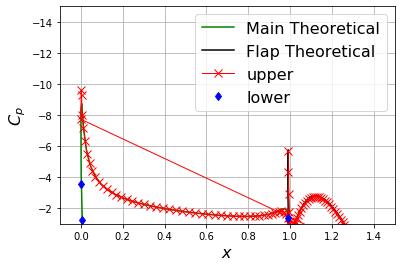

In [6]:
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)


pyplot.plot(xMainCPTheo, yMainCPTheo, label='Main Theoretical', linestyle='-', color='g')
pyplot.plot(xFlapCPTheo, yFlapCPTheo, label='Flap Theoretical', linestyle='-', color='k')

pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper',
            color='r', linewidth=1, marker='x', markersize=8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label='lower',
            color='b', linewidth=0, marker='d', markersize=6)

pyplot.legend(loc='best', prop={'size':16});
pyplot.xlim(-0.1, 1.5);
pyplot.ylim(-1.0, -15.0);

##### Questions

Run your codes using 100 panels on both main and flap airfoils and answer the following numeric-value questions.

### Q1.

* What is the pressure coefficient on the $3$<sup>rd</sup> panel on the *main airfoil*?

In [7]:
print('The Pressure Coefficient on the 3rd Panel on the Main Foil is: ', numpy.round(panels[2].cp, 3))

The Pressure Coefficient on the 3rd Panel on the Main Foil is:  -0.956


### Q2.

* What is the pressure coefficient on the $10$<sup>th</sup> panel on the *flap airfoil*?

In [8]:
print('The Pressure Coefficient on the 10th Panel on the Flap is: ', numpy.round(panels[N+9].cp, 3))

The Pressure Coefficient on the 10th Panel on the Flap is:  -0.28


### Q3.

* What is the value of lift?


**Hint:**  $~L = - \oint_{main}p\vec{n}\cdot\vec{j}dl- \oint_{flap}p\vec{n}\cdot\vec{j}dl$

In [9]:
lift = 0

for panel in panels:
    lift = lift - panel.cp * numpy.sin(panel.beta) * panel.length

print('The Lift is: ', numpy.round(lift, 3))

The Lift is:  3.698


### Q4.

* What is the value of drag?  

In [10]:
drag = 0

for panel in panels:
    drag = drag + panel.cp * numpy.cos(panel.beta) * panel.length

print('The Drag is: ', numpy.round(drag, 3))

The Drag is:  0.011


### Q5.

* Run the program again with 200 panels on both main and flap airfoils. What is the percentage of improvement of the absolute error in the value of lift?

In [11]:
N = fFoil200X.size - 1

u_inf = 1.0
alpha = 0.0

freestream = Freestream(u_inf, alpha)
mPanels = define_panels(mFoil200X, mFoil200Y, N)
fPanels = define_panels(fFoil200X, fFoil200Y, N)

panels = numpy.append(mPanels, fPanels)

ASource = source_contribution_normal(panels)
bVortex = vortex_contribution_normal(panels)

A = build_singularity_matrix(ASource, bVortex, N)
b = build_freestream_rhs(panels, freestream, N)

strength = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = strength[i]
    
gamma = strength[-2:]

compute_tangential_velocity(panels, freestream, gamma, ASource, bVortex)
compute_pressure_coefficient(panels, freestream)

lift200 = 0.0

for panel in panels:
    lift200 = lift200 - panel.cp * numpy.sin(panel.beta) * panel.length

liftTheoretical = 3.7386
err200 = numpy.abs(liftTheoretical - lift200)
err100 = numpy.abs(liftTheoretical - lift)
impro = numpy.abs(err200 - err100)/err100
impro = impro * 100

print('The precentage of Improvement is: ', numpy.round(impro, 3), '%')

The precentage of Improvement is:  50.677 %


## Part 2: Wenzinger's test case

You should now have a usable panel solver for 2-component airfoils. Next, you'll change the target airfoil to a more realistic profile. There are experimental results available (Wenzinger, 1938) for a NACA 23012 airfoil with a NACA23012 external-airfoil flap, which we'll compare with.

The following figure shows the profile of this wing section with 0º flap angle:

<center><img src="NACA23012withFlap.png" width=500> </center>

We provide CSV files for the endpoints of a panel discretization of this wing section, using 150 panels on each airfoil: `NACA23012_MainFoil.csv` and `NACA23012_FlapFoil.csv`.

The flap has a rotating center (hinge) at the location $(1.03, -0.054)$ (see the configuration on Figure 1 of the reference). Using coordinate rotation, you can obtain different configurations with different flap deflection angles.

Try to use different flap deflection angles and different angles of attack (of the main airfoil) and compare to Wenzinger's experimental results. Note that the definition of the total lift coefficient is $L/(l_{main}+l_{flap})$, where $L$ is the lift force (per unit span) like in the previous problem, and $l_{main}$ and $l_{flap}$ are the chord lengths of the two airfoils. **Think about what could be the sources of difference between your results and the experimental data**.

In [12]:
def flapAOA(xc, yc, x, y, AoA):
    AoA_rad = numpy.radians(AoA)
    
    xR = xc + (x - xc) * numpy.cos(AoA_rad) + (y - yc) * numpy.sin(AoA_rad)
    yR = yc - (x - xc) * numpy.sin(AoA_rad) + (y - yc) * numpy.cos(AoA_rad)
    
    return xR, yR

def liftCalc(panels, u_inf, alpha,  N):
    
    freestream = Freestream(u_inf, alpha)
    
    ASource = source_contribution_normal(panels)
    bVortex = vortex_contribution_normal(panels)

    A = build_singularity_matrix(ASource, bVortex, N)
    b = build_freestream_rhs(panels, freestream, N)

    strength = numpy.linalg.solve(A, b)

    for i, panel in enumerate(panels):
        panel.sigma = strength[i]

    gamma = strength[-2:]

    compute_tangential_velocity(panels, freestream, gamma, ASource, bVortex)
    compute_pressure_coefficient(panels, freestream)
    
    lift = 0.0
    
    for panel in panels: 
        lift = lift - panel.cp * numpy.sin(panel.beta) * panel.length
        
    drag = 0

    for panel in panels:
        drag = drag + panel.cp * numpy.cos(panel.beta) * panel.length
        
    return lift, drag

def bisection(panels, u_inf, alpha, N, maxIteration, rangeLower, rangeUpper,tolerance):
    
    liftCalcHold, _ = liftCalc(panels, u_inf, alpha, N)
    
    iteration = 0
    
    while iteration < maxIteration:
        alpha = (rangeUpper + rangeLower) / 2
        liftGuess, _ = liftCalc(panels, u_inf, alpha, N)
        
        print(iteration, alpha, liftGuess)
        
        if numpy.abs(rangeUpper - rangeLower) / 2 < tolerance:
            break
            
        if numpy.sign(liftGuess) == numpy.sign(liftCalcHold):
            rangeUpper = alpha
            liftCalcHold = liftGuess
            
        else: 
            rangeLower = alpha
            
        iteration = iteration + 1
        
    return alpha
    
def bisectionFlap(xMain, yMain, xFlap, yFlap, xC, yC, u_inf, alpha, N, maxIteration, rangeLower, rangeUpper, tolerance):
    
    xFlapHold, yFlapHold = flapAOA(xC, yC, xFlap, yFlap, 0.0)

    mPanels = define_panels(xMain, yMain, N)
    fPanels = define_panels(xFlapHold, yFlapHold, N)

    panels = numpy.append(mPanels, fPanels)
    
    liftCalcHold, _ = liftCalc(panels, u_inf, alpha, N)
    
    iteration = 0
    
    while iteration < maxIteration:
        
        alphaFlap = (rangeUpper + rangeLower) / 2
        
        xFlapGuess, yFlapGuess = flapAOA(xC, yC, xFlap, yFlap, alphaFlap)

        mPanels = define_panels(xMain, yMain, N)
        fPanels = define_panels(xFlapGuess, yFlapGuess, N)

        panels = numpy.append(mPanels, fPanels)
        
        liftGuess, _ = liftCalc(panels, u_inf, alpha, N)
        
        print(iteration, alphaFlap, liftGuess)
        
        if numpy.abs(rangeUpper - rangeLower) / 2 < tolerance:
            break
            
        if numpy.sign(liftGuess) == numpy.sign(liftCalcHold):
            rangeUpper = alphaFlap
            liftCalcHold = liftGuess
            
        else: 
            rangeLower = alphaFlap
            
        iteration = iteration + 1
        
    return alphaFlap

In [13]:
xMain, yMain = numpy.loadtxt('NACA23012_MainFoil.csv', dtype=float, delimiter=',', unpack=True)
xFlap, yFlap = numpy.loadtxt('NACA23012_FlapFoil.csv', dtype=float, delimiter=',', unpack=True)

xC, yC = 1.03, -0.054

xFlap20, yFlap20 = flapAOA(xC, yC, xFlap, yFlap, 20.0)

N = xMain.size - 1

u_inf = 1.0
alphaMain = 0.0
alphaFlap = 20.0

mPanels = define_panels(xMain, yMain, N)
fPanels = define_panels(xFlap20, yFlap20, N)

panels = numpy.append(mPanels, fPanels)

alpha = bisection(panels, u_inf, alpha, N, 20, -14.0, 14.0, 0.01)

0 0.0 1.5201862605266274
1 -7.0 0.5483384625523494
2 -10.5 0.06349890620405918
3 -12.25 -0.1754769487544667
4 -11.375 -0.05636954672633148
5 -10.9375 0.003476521424692291
6 -11.15625 -0.026469425555752435
7 -11.046875 -0.011502071227552276
8 -10.9921875 -0.004014166049861656
9 -10.96484375 -0.00026916839387743086
10 -10.951171875 0.0016035902083459893
11 -10.9580078125 0.0006671893038121595


In [14]:
alphaFlap = bisectionFlap(xMain, yMain, xFlap, yFlap, xC, yC, u_inf, 0.0, N, 
                          20, -10.0, 10.0, 0.01)

0 0.0 0.27191064446868785
1 -5.0 -0.029284938531412466
2 -2.5 0.12073395772163853
3 -3.75 0.04557839401876146
4 -4.375 0.008110012361247795
5 -4.6875 -0.010596666081001451
6 -4.53125 -0.001245624551723716
7 -4.453125 0.0034316198605975744
8 -4.4921875 0.0010928540962311037
9 -4.51171875 -7.642112327409047e-05
10 -4.501953125 0.0005082075133687798


In [15]:
incidence = 4.0
flapAngle = [0.0, 5.0, 10.0, 15.0]
liftAngle = numpy.empty_like(flapAngle)
dragAngle = numpy.empty_like(flapAngle)

i = 0

for i in range(0, numpy.size(flapAngle)):
    xFlapAngle, yFlapAngle = flapAOA(xC, yC, xFlap, yFlap, flapAngle[i])

    mPanels = define_panels(xMain, yMain, N)
    fPanels = define_panels(xFlapAngle, yFlapAngle, N)

    panels = numpy.append(mPanels, fPanels)
    
    liftAngle[i], dragAngle[i] = liftCalc(panels, u_inf, incidence, N)
    
print(liftAngle)
print(dragAngle)

percentSlower = numpy.empty_like(liftAngle)

i = 0
for i in range(0, numpy.size(liftAngle)):
    percentSlower[i] = (1 - numpy.sqrt(liftAngle[0]/liftAngle[i])) * 100

[0.82435976 1.12804895 1.43522694 1.74566936]
[0.05731872 0.07866282 0.10026415 0.12209081]


##### Questions

### Q1.

* Use the [bisection method](http://en.wikipedia.org/wiki/Bisection_method) to determine the angle of attack, $\alpha$, that will cause zero lift when the flap angle is $20$º. Round your answer to the second digit after the floating point.

**HINT**: you can start the bisection method within the range $-14\le\alpha\le14$.

In [16]:
print('The angle of attack, alpha, that will cause a zero lift is: ', numpy.round(alpha, 2))

The angle of attack, alpha, that will cause a zero lift is:  -10.96


### Q2.

* Use the [bisection method](http://en.wikipedia.org/wiki/Bisection_method) to determine the flap angle that will cause zero lift when the angle of attack, $\alpha$, is $0$º. Round your answer to the second digit after the floating point.

In [17]:
print('The flap angle that will cause a zero lift is: ', numpy.round(alphaFlap, 2))

The flap angle that will cause a zero lift is:  -4.5


### Q3.

* Suppose that the main airfoil is attached to the fuselage of an airplane at an incidence angle of $4$º (that is, the built-in angle of attack of the wing when the airplane is in level flight is $4$º). Compute the lift coefficient with the flap at $0$º deflection, and at $5$, $10$ and $15$ degrees. How much slower (in percentage) can the airplane fly (in level flight) with the flaps extended at these settings, compared with $0$º?

In [18]:
print('The lift coefficients with a 4 Degree Incidence angle, and a flap angle of 0, 5, 10, and 15 degrees are: ', 
      numpy.round(liftAngle, 3), 'respectively')
print('The percentage that the aircraft can fly slower at 5 degrees flap angle is: ', numpy.round(percentSlower[1],2))
print('The percentage that the aircraft can fly slower at 10 degrees flap angle is: ', numpy.round(percentSlower[2], 2))
print('The percentage that the aircraft can fly slower at 15 degrees flap angle is: ', numpy.round(percentSlower[3], 2))

The lift coefficients with a 4 Degree Incidence angle, and a flap angle of 0, 5, 10, and 15 degrees are:  [0.824 1.128 1.435 1.746] respectively
The percentage that the aircraft can fly slower at 5 degrees flap angle is:  14.51
The percentage that the aircraft can fly slower at 10 degrees flap angle is:  24.21
The percentage that the aircraft can fly slower at 15 degrees flap angle is:  31.28


##### Think

Think about the meaning of what you observed in **Q3**, above. What is the effect of using the flap?

Thinking about the observations in Q3, using the flap effects the characteristics of the air foil in a few differenent ways. First, by using the flap, the stall speed of the air foil is drastically decreased by 14% with just a small angle, and up to 31% with an angle of 15 degrees. Additionally, the amount of lift of the foil is increased with the flap. Since the aircraft can fly slower, there is a larger surface area that can be utilized for lift, which ultimately allows for a slower landing when the aircraft begins decent. 

## References

*  B. R. Williams (1973), *An Exact Test Case for the Plane Potential Flow About Two Adjacent Lifting Aerofoils*, Reports & Memoranda No. 3717, Aeronautical Research Council of the United Kingdom // [PDF at Cranfield University](http://naca.central.cranfield.ac.uk/reports/arc/rm/3717.pdf)

* C. J. Wenzinger (1938), *Pressure distribution over an NACA 23012 airfoil with an N.A.C.A. 23012 external-airfoil flap*, NACA Technical Report No.614 // [PDF at NASA](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19930091690.pdf)

-----------------------------